CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [86]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Some parameters

In [87]:
data_dir = pathlib.Path('/mnt/sdb/hyper-kvasir/labeled/')

config = {
    # Dataset
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "ds_info": 'hyp-kva',
    "resample": False,
    "shuffle_buffer_size": 0,
    "neg_class": ['normal-cecum'],
    "outcast": None,
    # Model
    "model": 'EfficientNetB0',
    "num_epochs": 100,
    "batch_size": 64,
    "img_shape": (224, 224, 3),
    "learning_rate": 0.01,
    "optimizer": 'Adam',
    "final_activation": 'softmax',
    # Callbacks
    "learning_schedule": True,
    "checkpoint": False,
    "early_stopping": True,
    "early_stopping_patience": 15,
    "decay_rate": 0.05,              # higher number gives steeper dropoff
    # Misc
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["num_epochs"], config["batch_size"], 
                                     config["img_shape"][1], config["ds_info"], config["model"])

fine_tune_from = 130
fine_tune_epochs = 30
early_stopping_patience = config["early_stopping_patience"]

Create training, testing and validation dataset from utils/data_prep.py

In [ ]:
train_ds, test_ds, val_ds, params = create_dataset(config)

train_steps = params["train_size"] // config["batch_size"]
test_steps = params["test_size"] // config["batch_size"]
val_steps = params["val_size"] // config["batch_size"]
class_names = params["class_names"]

## Training
### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [63]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [64]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=config["IMG_SIZE"]))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(params["NUM_CLASSES"], activation='softmax'))

In [ ]:
if config["verbosity"] > 0:
    cnn_model.summary()

Compile and train the model

In [65]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(config["MODEL"]), update_freq='batch')]

In [66]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 546 steps, validate for 117 steps
Epoch 1/5
546/546 [==============================] - 36s 66ms/step - loss: 0.3291 - accuracy: 0.8604 - val_loss: 0.3505 - val_accuracy: 0.8570
Epoch 2/5
546/546 [==============================] - 3s 6ms/step - loss: 0.2092 - accuracy: 0.9164 - val_loss: 0.1959 - val_accuracy: 0.9225
Epoch 3/5
546/546 [==============================] - 3s 5ms/step - loss: 0.1554 - accuracy: 0.9396 - val_loss: 0.1853 - val_accuracy: 0.9240
Epoch 4/5
546/546 [==============================] - 3s 5ms/step - loss: 0.1123 - accuracy: 0.9582 - val_loss: 0.3077 - val_accuracy: 0.8783
Epoch 5/5
546/546 [==============================] - 3s 5ms/step - loss: 0.0894 - accuracy: 0.9675 - val_loss: 0.1049 - val_accuracy: 0.9613


In [ ]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [67]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

117/117 - 21s - loss: 0.1023 - accuracy: 0.9635


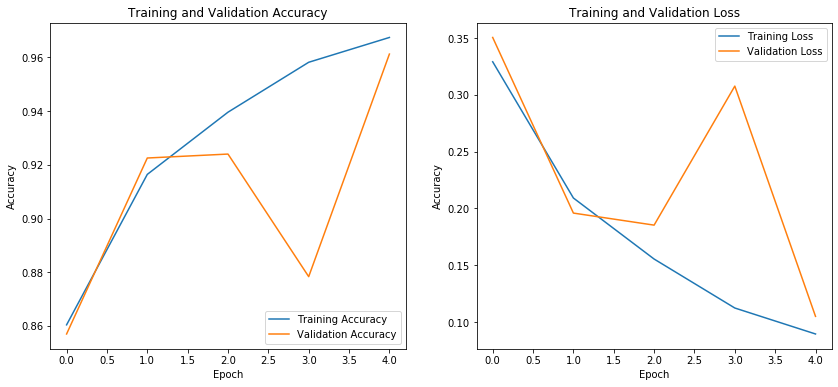

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [69]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

1.0000 Negative
0.0000 Positive

Label: Negative
Predicton: Negative


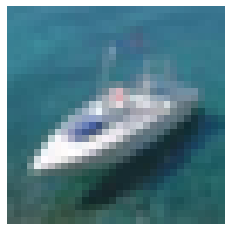

In [74]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [71]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------', end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------
  0  Negative    Negative  
  1  Positive    Positive  
  2  Negative    Negative  
  3  Negative    Negative  
  4  Positive    Positive  
  5  Negative    Negative  
  6  Positive    Positive  
  7  Negative    Negative  
  8  Negative    Negative  
  9  Negative    Negative  
 10  Negative    Negative  
 11  Negative    Negative  
 12  Negative    Negative  
 13  Positive    Positive  
 14  Negative    Negative  
 15  Negative    Negative  
 16  Positive    Positive  
 17  Positive    Positive  
 18  Positive    Negative    Wrong
 19  Positive    Positive  
 20  Negative    Negative  
 21  Negative    Negative  
 22  Negative    Negative  
 23  Negative    Negative  
 24  Negative    Negative  
 25  Positive    Positive  
 26  Positive    Positive  
 27  Positive    Positive  
 28  Negative    Negative  
 29  Positive    Positive  
 30  Positive    Positive  
 31  Positive    Positive  
 32  Positive    Positive  
 33  Positive    Posi